In [1]:
#Load the model and dependencies
import time, os, json
import numpy as np
from scipy.misc import imread, imresize
import matplotlib.pyplot as plt
import pickle
import cv2, numpy as np
from deconv_utils import *
import copy

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
#Load the VGG Model and ImageNet Class Mappings
from library.classifiers.pretrained_vgg16 import PretrainedVGG
model = PretrainedVGG(h5_file = 'Data/vgg16_weights.h5')
CLASSES = pickle.load(open('Data/CLASSES.pkl'))

In [3]:
#Input Image File
filename = 'Images/dog.jpg'
#Layer from which the image will be segment
layer = 11
#No of neurons to evaluate from ranked list
kmax = 7

In [6]:
im = load_image_cv2(filename)
activs, caches = get_activs(model, im)
class_no = np.argmax(activs[15][0])
print class_no, CLASSES[class_no]
#print [CLASSES[i] for i in np.argsort(-activs[15][0])[:5]]
#print  np.argsort(-activs[15][0])[:5]

246 Great Dane


Great Dane


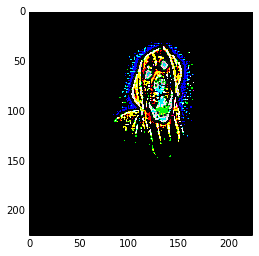

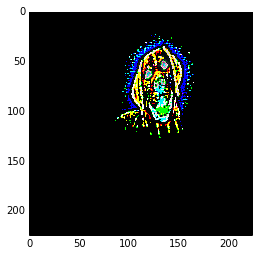

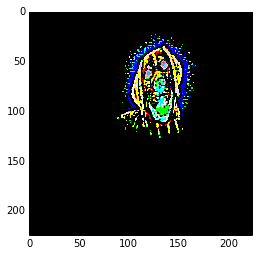

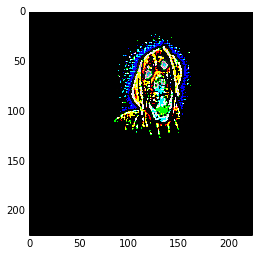

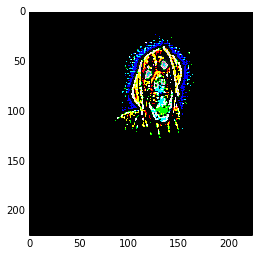

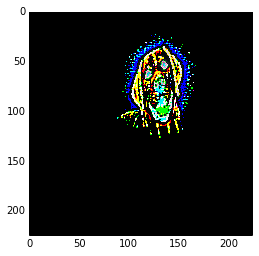

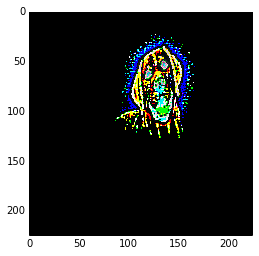

In [7]:
#Get Actives & Cache -Blob
# Set Class no if you want to force localize
#class_no=264
print CLASSES[class_no]
#Get Backgrad Up until the layer of choice
#This is used to rank the neurons to obtain best blobs
back_grad = get_backgrad(activs, model, class_no, layer, caches)

#Get the Filters of Interest in Sorted Order
amax = filter_of_intr(activs,back_grad,kmax,layer)
filter_scores = get_filter_scores(
    amax, model, im, activs,caches, layer, class_no,
    percentile_thresh=40,use_blob=True)

10.0491


(-0.5, 223.5, 223.5, -0.5)

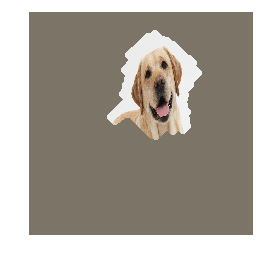

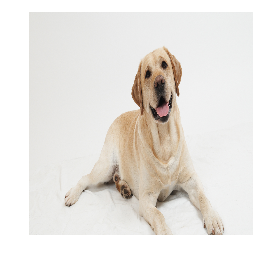

In [121]:
#Union Blobs
sorted_scores = sorted(filter_scores,key=lambda x:-x[1])
mask = np.zeros(im.shape)
for k in range(3):
    i,n_score,blob,xmin,xmax,ymin,ymax=sorted_scores[k]
    mask = (mask+blob)>0
newim = im.copy()*mask
#plt.imshow(newim[0].transpose(1,2,0))
plot_image_cv2(newim.copy())
plt.axis("off")
print n_score
plt.figure()
plot_image_cv2(im)
plt.axis("off")

246 Great Dane
15.2504


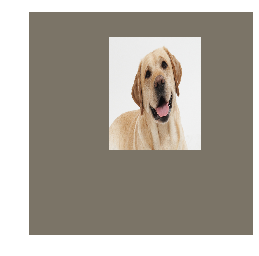

In [122]:
#Get Actives & Cache - no Blob
im = load_image_cv2(filename)
activs, caches = get_activs(model, im)
#class_no = np.argmax(activs[15][0])
print class_no, CLASSES[class_no]
#class_no=341
#Get Backgrad Up until the layer of choice
#This is used to rank the neurons to obtain best blobs
back_grad = get_backgrad(activs, model,class_no, layer, caches)

#Get the Filters of Interest in Sorted Order
amax = filter_of_intr(activs,back_grad,kmax,layer)
filter_scores = get_filter_scores(
    amax, model, im, activs,caches, layer, class_no,
    percentile_thresh=80,use_blob=False)


#Union Blobs
mask = np.zeros(im.shape)
for k in range(1):
    i,n_score,blob,xmin,xmax,ymin,ymax=sorted(filter_scores,key=lambda x:-x[1])[k]
    mask = (mask+blob)>0
newim = im.copy()*mask
#plt.imshow(newim[0].transpose(1,2,0))
plot_image_cv2(newim)
plt.axis("off")
print n_score

(-0.5, 223.5, 223.5, -0.5)

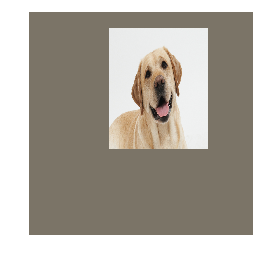

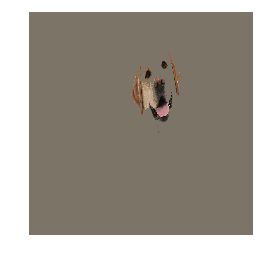

In [123]:
#GrabCut version of UnionBlob
im2 = im[0].transpose(1,2,0).astype('uint8')
im3 = load_image_cv2(filename)
ymin = xmin= 100000
ymax = xmax= -100000
for k in range(5):
    i,n_score,blob,xmin2,xmax2,ymin2,ymax2=sorted(filter_scores,key=lambda x:-x[1])[k]
    xmin = min(xmin,xmin2)
    ymin = min(ymin,ymin2)
    ymax = max(ymax,ymax2)
    xmax = max(xmax,xmax2)

bmask = np.zeros(im.shape)
bmask[0,:,xmin:xmax,ymin:ymax]=1
plot_image_cv2(im*bmask)
plt.axis("off")
mask = grabCut(im2,xmin,xmax,ymin,ymax)>0
mask2 = np.zeros(im3.shape)
mask2[:,0,:,:]= mask2[:,1,:,:]= mask2[:,2,:,:]= mask
newim = im3.copy()*mask2

#plt.imshow(newim[0].transpose(1,2,0))
plt.figure()
plot_image_cv2(newim)
#plt.imshow(mask)
plt.axis("off")

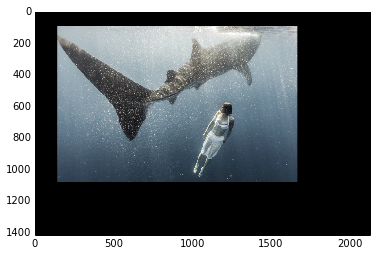

In [124]:
from library.localization import *

imgf = 'Images/dolph.jpg'
im = cv2.imread(imgf)

#Get Bounding Box
bbox_coords = bbox(im,model,class_no=338)
#Visualize the Box on the original image
visualize(im, bbox_coords)

In [89]:
filter(lambda x: 'pig' in CLASSES[x].lower(), range(1000))

[338, 341, 719, 833]

In [20]:
candidates = pickle.load(open("Data/validation_6.pkl"))
sorted_results = pickle.load(open("Data/sorteddata.pkl"))
result_row = sorted_results[i]
print result_row
coords = result_row[3]
_,_,_,_,xmin_r,xmax_r,ymin_r,ymax_r = coords
xmin_r,xmax_r,ymin_r,ymax_r  = int(xmin_r.strip()),int(xmax_r.strip()),int(ymin_r.strip()),int(ymax_r.strip())
print xmin_r,xmax_r,ymin_r,ymax_r

('validation_5_results.csv', 41, 0.955002, ['40', ' 465', ' 63', ' 327', '33', ' 462', ' 63', ' 321\n'])
33 462 63 321


In [19]:
import types
from library.image_utils import *

In [22]:
Param.num_dilation = 15

0.823973
('n01729322', 'n01729322_4208', 54, 261, 'http://www.sareptiles.co.za/gallery/albums/userpics/13204/DSCF1782.JPG', 101, 429, 32, 254)
hognose snake, puff adder, sand viper


NameError: name 'visualize' is not defined

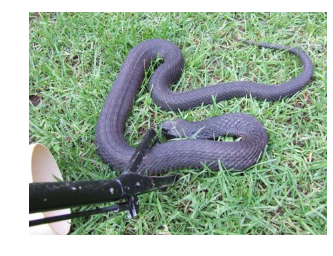

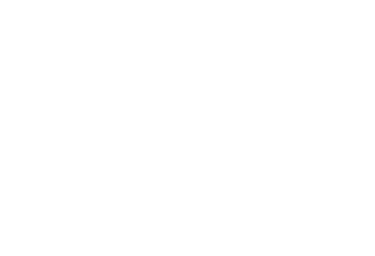

In [23]:
i=111
#Best/Worst Image Image
result_row = sorted_results[i]
file_name = result_row[0]
file_name = file_name.split("_")[0] + "_" + file_name.split("_")[1]
im_no = result_row[1]
coords = result_row[3]
print result_row[2]

bbox_coords = None
_,_,_,_,xmin_r,xmax_r,ymin_r,ymax_r = coords
xmin_r,xmax_r,ymin_r,ymax_r  = int(xmin_r.strip()),int(xmax_r.strip()),int(ymin_r.strip()),int(ymax_r.strip())
bbox_coords = (xmin_r,xmax_r,ymin_r,ymax_r)

candidates = pickle.load(open("Data/"+file_name+".pkl"))
for ret in candidates[im_no:(im_no+1)]:
    class_wnid,imgid,class_idx,xmlidx,url,xmin,xmax,ymin,ymax = ret
    print ret
    im = image_from_url(url) 
    plt.figure()
    plt.axis("off")
    im_1 = cv2.cvtColor(im, cv2.cv.CV_BGR2RGB)
    plt.imshow(im_1)
    if type(im) == types.NoneType:
        print "Skip (%d,%d): %s : URL is bad."%(class_idx,xmlidx,imgid)
    elif np.mean(im)>=253:
        print "Skipping Empty(White) Image"
    elif np.mean(im)<=2:
        print "Skipping Empty(Black) Image"
    else:
        if bbox_coords is None:
            bbox_coords = bbox(im,model,class_no=class_idx,n_neurons = 5,kmax=10)
        print(CLASSES[class_idx])
        #Visualize the Box on the original image
        plt.figure()
        plt.axis("off")
        visualize(im, bbox_coords)
        plt.figure()
        plt.axis("off")
        visualize(im, (xmin,xmax,ymin,ymax))
        print eval_precision(bbox_coords, (xmin,xmax,ymin,ymax))
print i        
i+=1

In [236]:
import urllib2, os, tempfile
from socket import error as SocketError
def image_from_url(url):
  """
  Read an image from a URL. Returns a numpy array with the pixel data.
  We write the image to a temporary file then read it back. Kinda gross.
  """
  try:
    f = urllib2.urlopen(url)
    _, fname = tempfile.mkstemp()
    with open(fname, 'wb') as ff:
      ff.write(f.read())
    img = cv2.imread(fname)
    os.remove(fname)
    return img
  except urllib2.URLError as e:
    print 'URL Error: ', e.reason, url
  except urllib2.HTTPError as e:
    print 'HTTP Error: ', e.code, url
  except ValueError as e:
    print 'Some Error: ', url
  except SocketError as e:
    print 'Some Error: ', url

In [115]:
from library.localization import *
print eval_precision((0,100,0,100), (120,200,25,50))

0 100
120 200
0 100
25 50
0 25
0.0


915
913
0.464881788609


(array([  59.,   39.,   76.,  138.,  151.,  154.,  138.,  103.,   40.,   15.]),
 array([ 0.       ,  0.0956805,  0.191361 ,  0.2870415,  0.382722 ,
         0.4784025,  0.574083 ,  0.6697635,  0.765444 ,  0.8611245,
         0.956805 ]),
 <a list of 10 Patch objects>)

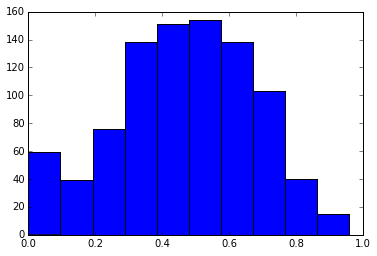

In [165]:
lines = open("../../assignment3/allres.csv").readlines()
print len(lines)
data = [ x.split(",") for x in  lines]
data = filter( lambda x : x[1].strip() != "FAIL", data)
print len(data1)
IoUs = map( lambda x: float(x[4].strip()) , data)
print np.mean(IoUs)
plt.hist(IoUs)

In [131]:
faildata= filter( lambda x : float(x[4].strip()) == 0.0, data)


In [132]:
class_idx = int(faildata[0][2].strip())
xmlidx = int(faildata[0][3].strip())

In [162]:
def center_correctness(row,factor = 0.3):
    eightnums = map(lambda x: float(x.strip()), row[5:])
    xmin, xmax, ymin, ymax,xmin_out, xmax_out, ymin_out, ymax_out =  eightnums
    mean_x = (xmax_out+xmin_out)/2
    mean_y = (ymax_out+ymin_out)/2
    w = xmax-xmin
    h = ymax-ymin
    txmax = xmax - factor*w
    txmin = xmin + factor*w
    tymax = ymax - factor*h
    tymin = ymin + factor*h
    return (txmin < mean_x < txmax)  and (tymin < mean_y < tymax)

In [205]:
cc_score = map( lambda row: center_correctness(row,factor = 0.15) ,data)

In [206]:
np.mean(cc_score)

0.84556407447973714

(array([   7.,   25.,   66.,  109.,  132.,  139.,  111.,   92.,   34.,   14.]),
 array([ 0.06935  ,  0.1580955,  0.246841 ,  0.3355865,  0.424332 ,
         0.5130775,  0.601823 ,  0.6905685,  0.779314 ,  0.8680595,
         0.956805 ]),
 <a list of 10 Patch objects>)

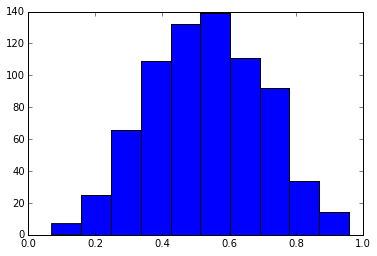

In [196]:
IoUs=np.array(IoUs)
plt.hist(IoUs[np.where(cc_score)[0]])

In [202]:
cc_score = lambda  f: np.mean(map( lambda row: center_correctness(row,factor = f) ,data))

In [203]:
fs = np.linspace(0,0.5,30)
ccs = map(cc_score,fs)

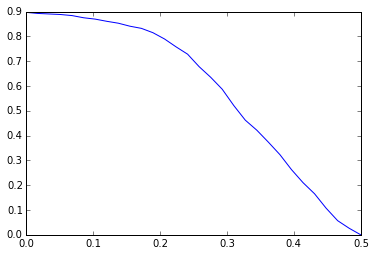

In [204]:
plt.plot(fs,ccs)

In [215]:
def rect_norm(row):
    eightnums = map(lambda x: float(x.strip()), row[5:])
    xmin, xmax, ymin, ymax,xmin_out, xmax_out, ymin_out, ymax_out =  eightnums
    mean_xo = (xmax_out+xmin_out)/2
    mean_yo = (ymax_out+ymin_out)/2
    mean_x = (xmax+xmin)/2
    mean_y = (ymax+ymin)/2
    wo = xmax_out-xmin_out
    ho = ymax_out-ymin_out
    w = xmax-xmin
    h = ymax-ymin

    ovec = np.array([mean_xo,mean_yo,wo,ho])
    vec = np.array([mean_x,mean_y,w,h])
    return np.linalg.norm(vec-ovec)

In [221]:
rn_score = np.array(map( lambda row: rect_norm(row) ,data))
np.mean(rn_score)

158.8569206674828

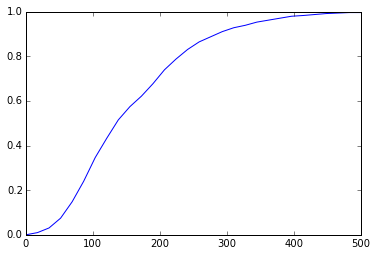

In [225]:
threshes = fs = np.linspace(0,500,30)
rns = map( lambda thresh : np.mean(rn_score<thresh) ,threshes)
plt.plot(threshes,rns)

In [11]:
sorted_results_2 = pickle.load(open("Data/sorteddata2.pkl"))
result_row = sorted_results_2[0]
print result_row
coords = result_row[3]
_,_,_,_,xmin_r,xmax_r,ymin_r,ymax_r = coords
xmin_r,xmax_r,ymin_r,ymax_r  = int(xmin_r.strip()),int(xmax_r.strip()),int(ymin_r.strip()),int(ymax_r.strip())
print xmin_r,xmax_r,ymin_r,ymax_r

('validation_10_results.csv', 241, 0.749448, array(['0', ' 373', ' 0', ' 498', '25', ' 348', ' 33', ' 464\n'], 
      dtype='|S32'), 0.00100401606426)
25 348 33 464


1.75925925926
('n02137549', 'n02137549_1338', 298, 314, 'http://farm2.static.flickr.com/1409/1465660820_b7e389a2e7.jpg', 149, 208, 114, 141)
mongoose
0.0627906976744
-102


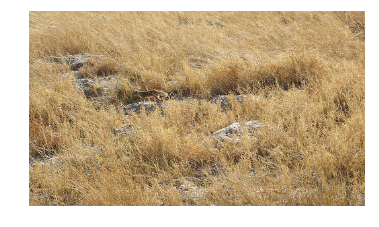

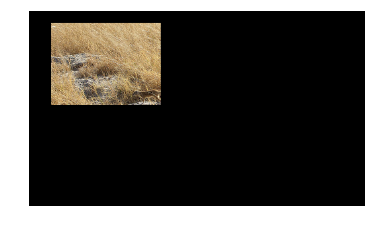

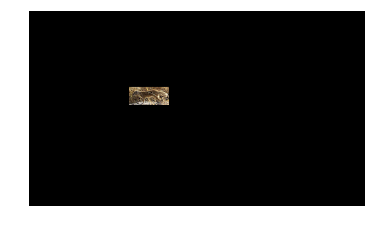

In [33]:
#Best/Worst Image Image
result_row = sorted_results_2[i]
file_name = result_row[0]
file_name = file_name.split("_")[0] + "_" + file_name.split("_")[1]
im_no = result_row[1]
coords = result_row[3]
print result_row[-1]

bbox_coords = None
_,_,_,_,xmin_r,xmax_r,ymin_r,ymax_r = coords
xmin_r,xmax_r,ymin_r,ymax_r  = int(xmin_r.strip()),int(xmax_r.strip()),int(ymin_r.strip()),int(ymax_r.strip())
bbox_coords = (xmin_r,xmax_r,ymin_r,ymax_r)

candidates = pickle.load(open("Data/"+file_name+".pkl"))
for ret in candidates[im_no:(im_no+1)]:
    class_wnid,imgid,class_idx,xmlidx,url,xmin,xmax,ymin,ymax = ret
    print ret
    im = image_from_url(url) 
    plt.figure()
    plt.axis("off")
    im_1 = cv2.cvtColor(im, cv2.cv.CV_BGR2RGB)
    plt.imshow(im_1)
    if type(im) == types.NoneType:
        print "Skip (%d,%d): %s : URL is bad."%(class_idx,xmlidx,imgid)
    elif np.mean(im)>=253:
        print "Skipping Empty(White) Image"
    elif np.mean(im)<=2:
        print "Skipping Empty(Black) Image"
    else:
        if bbox_coords is None:
            bbox_coords = bbox(im,model,class_no=class_idx,n_neurons = 5,kmax=10)
        print(CLASSES[class_idx])
        #Visualize the Box on the original image
        plt.figure()
        plt.axis("off")
        visualize(im, bbox_coords)
        plt.figure()
        plt.axis("off")
        visualize(im, (xmin,xmax,ymin,ymax))
        print eval_precision(bbox_coords, (xmin,xmax,ymin,ymax))

print i        
i-=1

In [24]:
from deconv_utils import *
from library.localization import *